# What are our favorite health systems?
### From those discussed by Reid in "Sick Around the World"

In this notebook I'm going to use some simple NLP to try to explore what were our favorite health systems. In the process I hope to demonstrate some of the data-wrangling challenges that go along with NLP.

### Get Data from Canvas

Canvas has a RESTful API. I'm going to use it to pull down the responses to the homework assignments.

By the way, you can also use the Canvas API to access your data.

The cell below contains the code I used to get the data from Canvas.

```Python
import os
with open(os.path.join(os.path.expanduser("~"), ".canvaslms", "quiz_token")) as f:
    token = f.read()
    
from canvasapi import Canvas
from bs4 import BeautifulSoup
import unicodedata


API_URL = "https://canvas.lms.unimelb.edu.au/"
canvas = Canvas(API_URL, token)
bec = canvas.get_user(canvas.get_current_user().id)
ehealth = canvas.get_course(110024)

assignments = ehealth.get_assignments()

for a in assignments:
    print(a)

# This is the id number for the assignment
healthsystem_id = 139425

healthsystems = ehealth.get_assignment(healthsystem_id)

healthsystem_submissions = healthsystems.get_submissions()

responses = [(b.user_id, b.body) for b in healthsystem_submissions]


len(responses)

len(set([r[0] for r in responses]))

healthsystem_text = [unicodedata.normalize("NFKC", BeautifulSoup(r[1]).getText()) for r in responses if r[1]]

with open("health_systems.json", "w") as f:
    json.dump(healthsystem_text, f)
```

In [1]:
import os
import pandas as pd
from collections import Counter
import json
# get token
import random
import matplotlib.pyplot as plt


### 

In [2]:
with open("health_systems.json", "r") as f:
    healthsystem_text = json.load(f)

In [3]:
healthsystem_text

["By watching sick around the world, I think Taiwan's medical system is the one I like the most.\nFrom the perspective of people's experience, it is very similar to the system being used in mainland China. Almost everyone has the right to medical insurance, and then the government will pay for all mainstream medical care, and the people only need to pay the basic expenses. The most convenient thing in this system is the use of the medical insurance card, which is quite convenient. By recording the user's medical history in detail, the doctor can see the patient's condition at a glance and make a proper diagnosis. Moreover, the payment information of the user is also stored in the card, which makes the payment extremely convenient and extremely friendly to the elderly and the disabled.\nThis highly unified system also eliminates waiting time, allowing people to receive treatment in time before their body conditions change, which can greatly improve people's recovery rate and satisfactio

### We are going to use the very popular [Spacy](https://spacy.io/) NLP package.

If you are interested in learning more about Spacy, we have some notebooks [here](https://github.com/Melbourne-BMDS/md3nlp_20020) that you can run online with binder to learn more.

In [4]:
import spacy
from IPython.display import SVG, YouTubeVideo
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
from spacy.lemmatizer import Lemmatizer
from spacy.matcher import Matcher


#### Entity Recognition

Spacy will parse the sentences and then try to recognize different entitites that are named in the text, such as people or organizations or diseases. Let's see how it works.

In [5]:
for txt in healthsystem_text:
    doc = nlp(txt)
    displacy.render(doc, style="ent")
    print('-'*72)

------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


### My Examination of the results indicates three [entity types](https://spacy.io/api/annotation#named-entities) of interest

- __GPE__: Geopolitical entity
    - e.g. UK
- __NORP__: Nationalities or religious or political groups
    - e.g. British
- __ORG__: Organization
    - e.g. National Health Service

In [6]:
displacy.render(doc, style="ent")

### Filtering Entities

Let's reduce the number of the recognized entities by only keeping entities that might conceivably be one of our healthsystems.

In [7]:
healthsystems = []
labels = ['GPE', 'NORP', 'ORG']
for txt in healthsystem_text:
    doc = nlp(txt)
    healthsystems.append([ent.lemma_.strip() for ent in doc.ents if ent.label_ in labels and ent.string != 'GP'])


In [8]:
analysis = []
for r in healthsystems:
    try:
        analysis.append({"first":r[0], "counter":Counter(r)})
    except:
        analysis.append({})
    

In [9]:
analysis

[{'first': 'Taiwan', 'counter': Counter({'Taiwan': 1, 'China': 1})},
 {'first': "New Zealand 's", 'counter': Counter({"New Zealand 's": 2})},
 {'first': 'Chinese',
  'counter': Counter({'Chinese': 1,
           'Taiwan': 4,
           'chinese': 1,
           'China': 2,
           'Taiwanese': 1})},
 {'first': 'Taiwan', 'counter': Counter({'Taiwan': 3, 'China': 1})},
 {'first': 'Taiwan', 'counter': Counter({'Taiwan': 4})},
 {'first': 'british',
  'counter': Counter({'british': 2,
           'UK': 1,
           'the National Health Service': 1})},
 {},
 {'first': 'Japan', 'counter': Counter({'Japan': 3})},
 {'first': 'Switzerland',
  'counter': Counter({'Switzerland': 3, 'UK': 1, 'Japan': 1})},
 {'first': 'Japan', 'counter': Counter({'Japan': 1, 'japanese': 3})},
 {'first': 'Healthcare',
  'counter': Counter({'Healthcare': 1, 'Taiwan': 1, 'japanese': 1})},
 {'first': 'Switzerland', 'counter': Counter({'Switzerland': 2, 'swiss': 1})},
 {'first': 'japanese',
  'counter': Counter({'japane

## 6 Countries

There were a couple of countries selected that were not part of Reid's documentary. I'm going to ignore those. Here rather than combing the GPE, NORP, and ORG categories I'm going to create my own entity and use Spacy's pattern matching to identify them.

In [10]:
from spacy.pipeline import EntityRuler

ruler = EntityRuler(nlp)

_us_patterns = [[{"LOWER":"united"}, {"LOWER":"states"}],
               [{"LOWER":"usa"}], 
               [{"LOWER":"u.s.a"}],
               [{"LOWER":"u.s."}],
               [{"LOWER":"america"}]]
_uk_patterns = [[{"LOWER":"uk"}],
               [{"LOWER":"britian"}],
               [{"LOWER":"british"}],
               [{"LOWER":"united"}, {"LOWER":"kingdom"}],
               [{"LOWER":"nhs"}]]
_ch_patterns = [[{"LOWER":"switzerland"}],
               [{"LOWER":"swiss"}]]
_de_patterns = [[{"LOWER":"germany"}],
               [{"LOWER":"german"}]]
_jp_patterns = [[{"LOWER":"japan"}],
               [{"LOWER":"japanese"}]]
_tw_patterns = [[{"LOWER":"taiwan"}],
               [{"LOWER":"taiwanese"}]]

In [11]:
us_patterns = [{"label":"HEALTHSYSTEM", "pattern":p, "id":"USA"} for p in _us_patterns]
uk_patterns = [{"label":"HEALTHSYSTEM", "pattern":p, "id":"UK"} for p in _uk_patterns]
ch_patterns = [{"label":"HEALTHSYSTEM", "pattern":p, "id":"CH"} for p in _ch_patterns]
de_patterns = [{"label":"HEALTHSYSTEM", "pattern":p, "id":"DE"} for p in _de_patterns]
jp_patterns = [{"label":"HEALTHSYSTEM", "pattern":p, "id":"JP"} for p in _jp_patterns]
tw_patterns = [{"label":"HEALTHSYSTEM", "pattern":p, "id":"TW"} for p in _tw_patterns]

In [12]:
ruler.add_patterns(us_patterns+uk_patterns+ch_patterns+de_patterns+jp_patterns+tw_patterns)

In [13]:
nlp.add_pipe(ruler)

### I'm disability Spacy's NER so that only my entity detector is used

In [14]:
analysis = []
for doc in nlp.pipe(healthsystem_text, disable=['ner']):
    displacy.render(doc, style="ent")
    tmp = [ent.ent_id_ for ent in doc.ents]
    try:
        analysis.append({"first":tmp[0], "counter":Counter(tmp)})
    except:
        analysis.append({})
    print('-'*72)

------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


/Users/brian/anaconda3/envs/nlp/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


------------------------------------------------------------------------


### Similar to what I did with rebels
#### Select either most frequently mentioned or if ties, the first mentioned

In [15]:
def get_most_common_or_first(data):
    c = data["counter"]
    mc_count = c.most_common(1)[0][1]
    vals = [k for k,v in c.items() if v==mc_count]
    if len(vals) > 1:
        return data["first"]
    else:
        return vals[0]

In [16]:
temp = [get_most_common_or_first(a) if a  else None for a in analysis]

In [17]:
temp

['TW',
 None,
 'TW',
 'TW',
 'TW',
 'UK',
 None,
 'JP',
 'CH',
 'JP',
 'TW',
 'CH',
 'JP',
 'DE',
 'JP',
 'DE',
 'JP',
 'JP',
 'JP',
 'JP',
 'UK',
 'JP',
 'JP',
 'JP',
 'UK',
 'JP',
 'TW',
 'TW',
 'JP',
 'USA',
 'JP',
 'JP',
 'JP',
 'JP',
 'JP',
 None,
 'DE',
 'TW',
 'DE',
 'TW',
 'TW',
 'CH',
 'JP',
 'TW',
 None,
 'JP',
 'TW',
 'JP',
 'TW',
 'TW',
 'TW',
 'TW',
 'JP',
 'JP',
 'TW',
 'JP',
 'JP',
 'UK',
 'UK',
 'JP',
 'JP',
 'JP',
 'CH',
 None,
 'TW',
 'TW',
 'TW',
 'CH',
 'UK',
 'CH']

In [18]:
for choice, text in zip(temp, healthsystem_text):
    print(choice)
    print(text)
    print("-"*40)

TW
By watching sick around the world, I think Taiwan's medical system is the one I like the most.
From the perspective of people's experience, it is very similar to the system being used in mainland China. Almost everyone has the right to medical insurance, and then the government will pay for all mainstream medical care, and the people only need to pay the basic expenses. The most convenient thing in this system is the use of the medical insurance card, which is quite convenient. By recording the user's medical history in detail, the doctor can see the patient's condition at a glance and make a proper diagnosis. Moreover, the payment information of the user is also stored in the card, which makes the payment extremely convenient and extremely friendly to the elderly and the disabled.
This highly unified system also eliminates waiting time, allowing people to receive treatment in time before their body conditions change, which can greatly improve people's recovery rate and satisfaction

### Use Pandas and Matplotlib to plot counts

Text(0.5, 0, 'Counts')

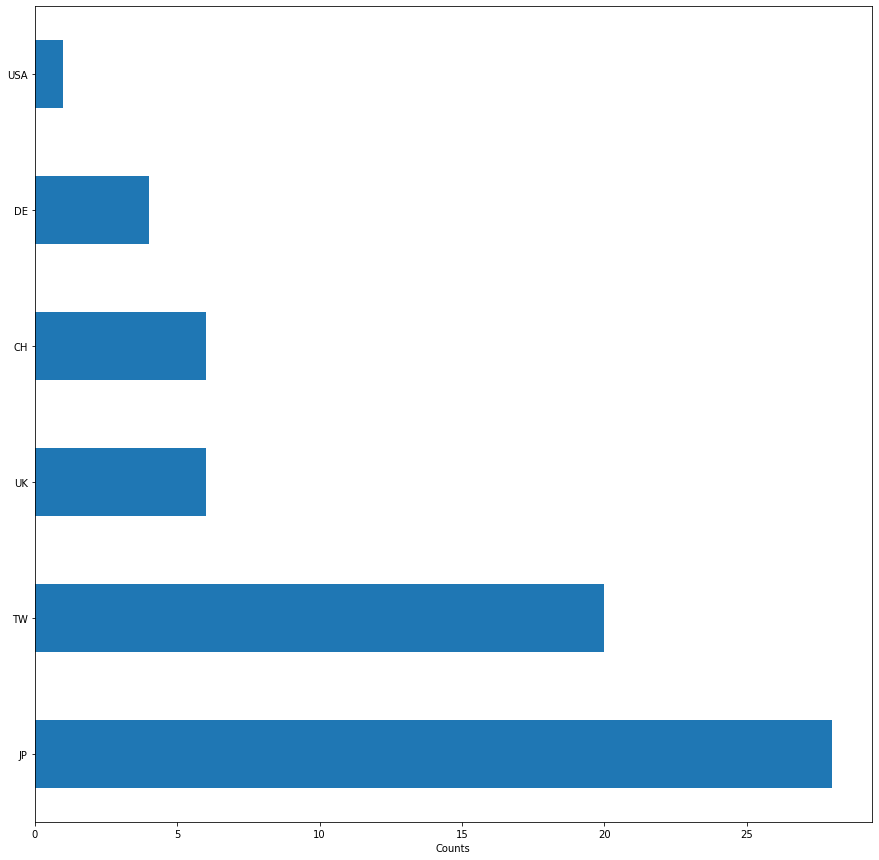

In [19]:
f, axs = plt.subplots(1,figsize=(15,15))
pd.DataFrame([x for x in temp])[0].value_counts().head(60).plot.barh(axes=axs)
axs.set_xlabel("Counts")


In [20]:
f.savefig("identified_healthsystems.png")